In [1]:
from pandas import read_csv, DataFrame
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from numpy import array, zeros
from matplotlib import pyplot as plt
import seaborn as sns
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import KernelKMeans
from statsmodels.tsa.stattools import acf

/home/pe/Documents/M2/Data/tp/.venv/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Chargement, clean et traitement des données

In [2]:
# Data cleaning and fitting
# retrive from here https://www.kaggle.com/datasets/stackoverflow/stacksample/data
raw_answers: DataFrame = read_csv('./data/Answers.csv', encoding='latin-1')
raw_questions: DataFrame = read_csv('./data/Questions.csv', encoding='latin-1')
raw_tags: DataFrame = read_csv('./data/Tags.csv', encoding='latin-1')
questions = raw_questions.copy()
answers = raw_answers.copy()
tags = raw_tags.copy()
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.reset_index()
tags = tags.groupby('Id')['Tag'].apply(list).reset_index()
questions = questions.join(tags['Tag'], on='Id')

# Keep only top 10 tags
top_tags = tags['Tag'].explode().value_counts().nlargest(10).index

# Drop NaN values
questions_top = questions.dropna(subset=['Tag'])


# Remove rows with tags not in top_tags
questions_top = questions_top[questions_top['Tag'].apply(lambda tags: any(tag in top_tags for tag in tags))]
questions_top.reset_index()
questions_top['CreationDate'] = pd.to_datetime(questions_top['CreationDate'])
questions_top['CreationDate'] = questions_top['CreationDate'].dt.date

In [3]:
# For see data set
pd.set_option('display.max_columns', None)
questions_top
# For each tag, count the number of questions moy by day
questions_top['CreationDate'] = pd.to_datetime(questions_top['CreationDate'])
questions_top['CreationDate'] = questions_top['CreationDate'].dt.date

# Trend seasonality and residuals

## CAF of spésifique periode

In [4]:
# Taite data to have spésifique période to analyse
date_start = '2008-09-15'
date_end = '2009-08-15'

question_moy_by_day = questions.copy()
answers_moy_by_day = answers.copy()
question_moy_by_day['CreationDate'] = question_moy_by_day['CreationDate'].str[:10]
answers_moy_by_day['CreationDate'] = answers_moy_by_day['CreationDate'].str[:10]

# Keep only creation date before 2009-08-15 it is Monday
answers_moy_by_day = answers_moy_by_day[answers_moy_by_day['CreationDate'] < date_end]
question_moy_by_day = question_moy_by_day[question_moy_by_day['CreationDate'] < date_end]

# Keep only creation date after 2008-09-15 it is Sunday
answers_moy_by_day = answers_moy_by_day[answers_moy_by_day['CreationDate'] > date_start]
question_moy_by_day = question_moy_by_day[question_moy_by_day['CreationDate'] > date_start]

question_moy_by_day_for_plot = question_moy_by_day['CreationDate'].value_counts().sort_index()
answers_moy_by_day_for_plot = answers_moy_by_day['CreationDate'].value_counts().sort_index()

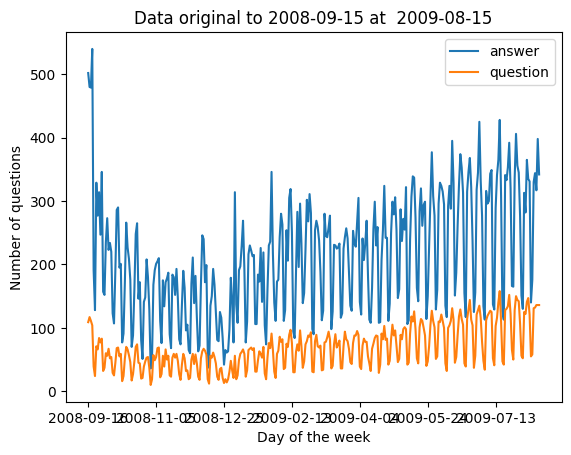

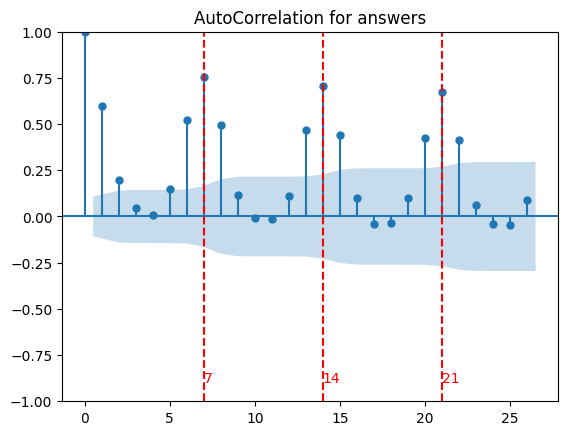

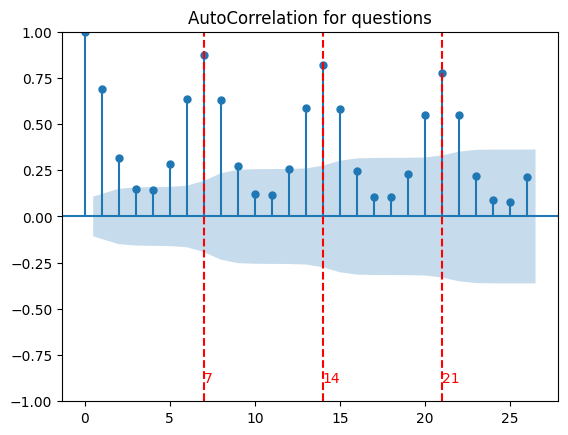

In [5]:
# See data to analyse
ax = answers_moy_by_day_for_plot.plot()
question_moy_by_day_for_plot.plot(ax=ax)

ax.legend(['answer', 'question'])
ax.set_xlabel('Day of the week')
ax.set_ylabel('Number of questions')

plt.title(f"Data original to {date_start} at  {date_end}")

# save plot
plt.savefig('plot.png')


# Plot ACF for answers
plot_acf(answers_moy_by_day_for_plot)
plt.title("AutoCorrelation for answers")
acf_answers_values = acf(answers_moy_by_day_for_plot)
top_3_lags_answers = np.argsort(acf_answers_values)[-4:-1]  # Exclude lag 0
for lag in top_3_lags_answers:
    plt.axvline(x=lag, color='r', linestyle='--')
    plt.text(x=lag, y=-0.9, s=f'{lag}', rotation=0, color='red')
plt.savefig('acf/plot_acf_answer_with_lags.png')

# Plot ACF for questions
plot_acf(question_moy_by_day_for_plot)
plt.title("AutoCorrelation for questions")
acf_questions_values = acf(question_moy_by_day_for_plot)
top_3_lags_questions = np.argsort(acf_questions_values)[-4:-1]  # Exclude lag 0
for lag in top_3_lags_questions:
    plt.axvline(x=lag, color='r', linestyle='--')
    plt.text(x=lag, y=-0.9, s=f'{lag}', rotation=0, color='red')
plt.savefig('acf/plot_acf_questions_with_lags.png')

# plt.savefig('acf/plot_acf_answer.png')

# plot_acf(question_moy_by_day_for_plot)
# plt.title("AutoCorrelation for questions")
# plt.savefig('acf/plot_acf_questions.png')

Nous remarquons que le meilleur cycle est de taille 7. Ce qui semble logique car cela corespind a une semaine. La fin de semaine possède moins de questions/réponse. De plus les Q et R augmente du lundi au jeudi cf FirstAnalysePlot.py

## Time Warping

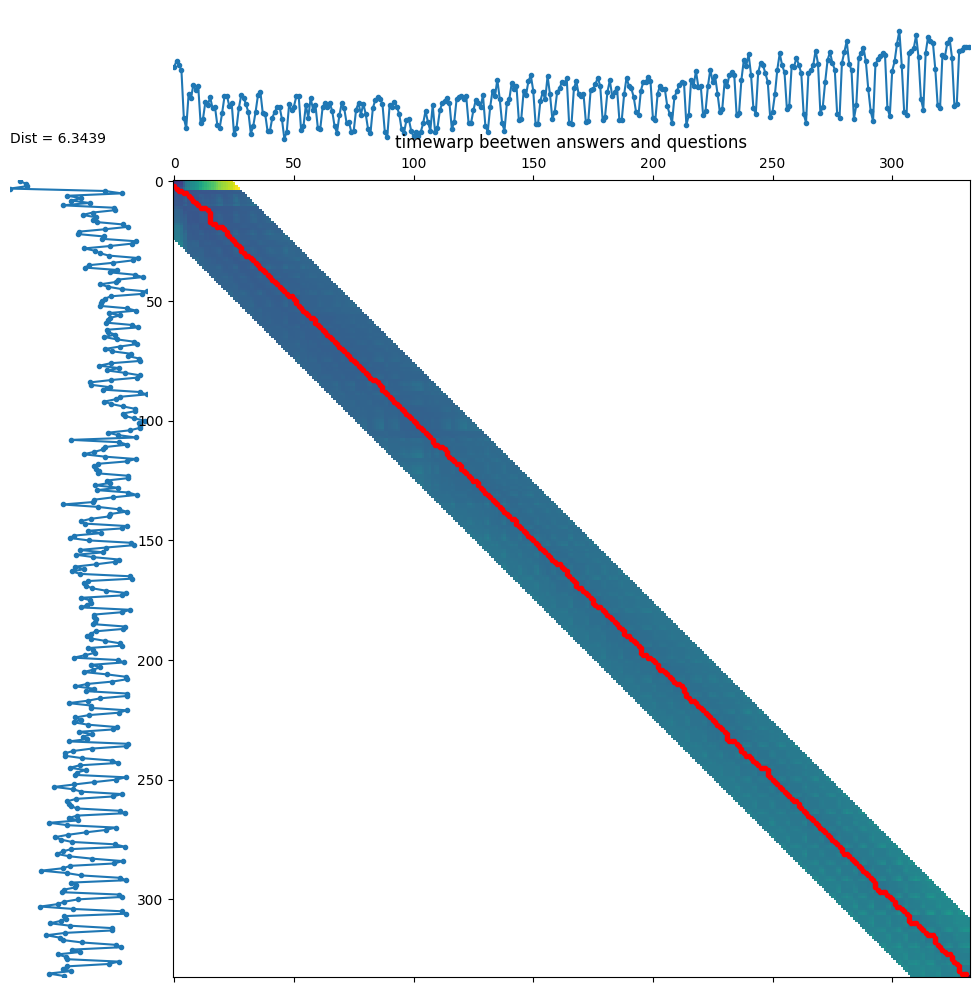

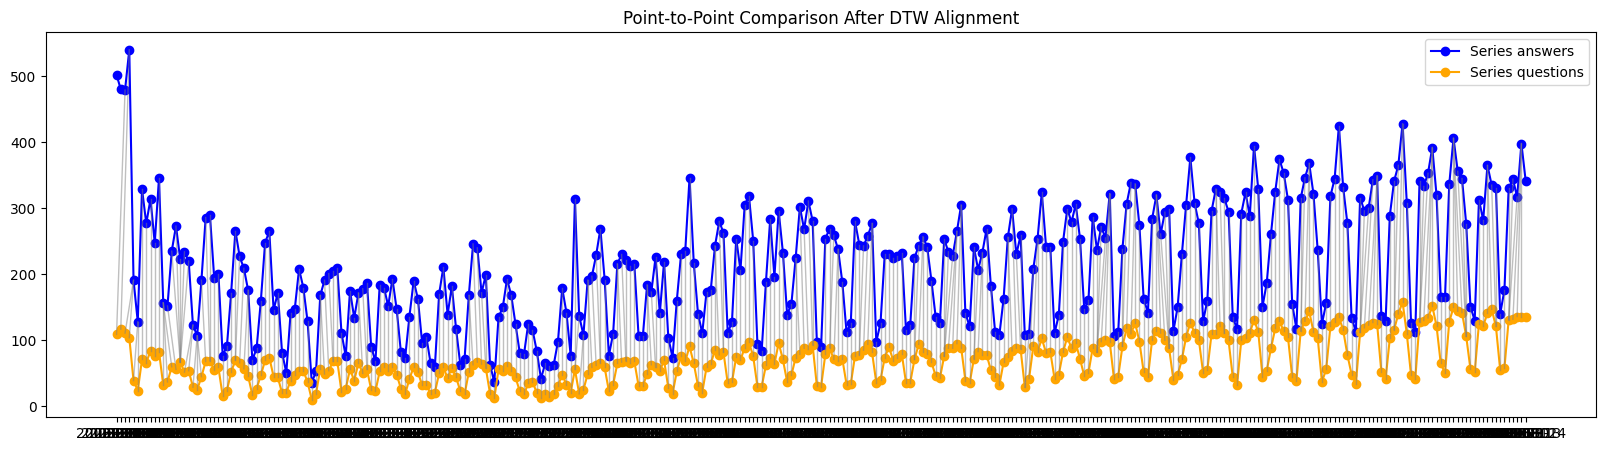

In [6]:
s1 = answers_moy_by_day_for_plot
s2 = question_moy_by_day_for_plot

# Centred and normalized. We must make this because we have lot of more answers than question
s1 = (s1 - s1.mean()) / s1.std()
s2 = (s2 - s2.mean()) / s2.std()

d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)
plt.title("timewarp beetwen answers and questions")
plt.savefig('timewarp/plot_dtw_question_answer.png')



# For the plot : https://medium.com/@markstent/dynamic-time-warping-a8c5027defb6
plt.figure(figsize=(20, 5))
plt.plot(answers_moy_by_day_for_plot, label='Series answers', color='blue', marker='o')
plt.plot(question_moy_by_day_for_plot, label='Series questions', color='orange', marker='o')
for a, b in best_path:
    plt.plot([a, b], [answers_moy_by_day_for_plot[a], question_moy_by_day_for_plot[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
plt.title('Point-to-Point Comparison After DTW Alignment')
plt.legend()


Nous pouvons voir qu'en effet les deux courbe sont similaire, il n'y a pas de décalage de temps. En conclusion les questions n'entraine pas plus de réponse. C'est les jours de travail clasique et les tendances global qui entraine plus ou moins de Q et R

## Detection d'anomlie avec Saisonnalité, tendance et résidual

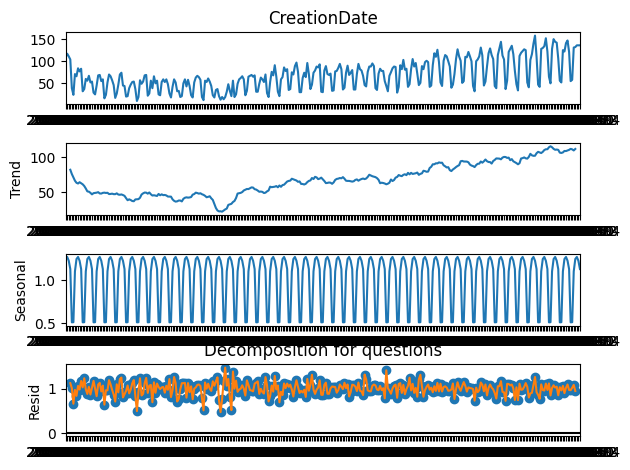

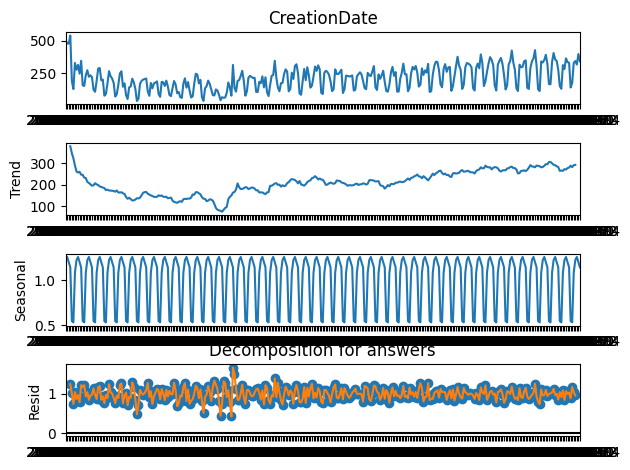

In [7]:
# Use seasonal_decompose from statsmodels.tsa.seasonal
# TODO mettre le site web de référence
decompose_result_mult = seasonal_decompose(question_moy_by_day_for_plot, model='multiplicative', period=7)
question_trend = decompose_result_mult.trend
question_seasonal = decompose_result_mult.seasonal
question_residual = decompose_result_mult.resid
decompose_result_mult.plot()
plt.title("Decomposition for questions")
ax = question_residual.plot()
plt.savefig('decompose_question_result_mult.png')

decompose_result_mult = seasonal_decompose(answers_moy_by_day_for_plot, model='multiplicative', period=7)
answers_trend = decompose_result_mult.trend
answers_seasonal = decompose_result_mult.seasonal
answers_residual = decompose_result_mult.resid
decompose_result_mult.plot()
plt.title("Decomposition for answers")
ax = answers_residual.plot()
plt.savefig('decompose_answers_result_mult.png')



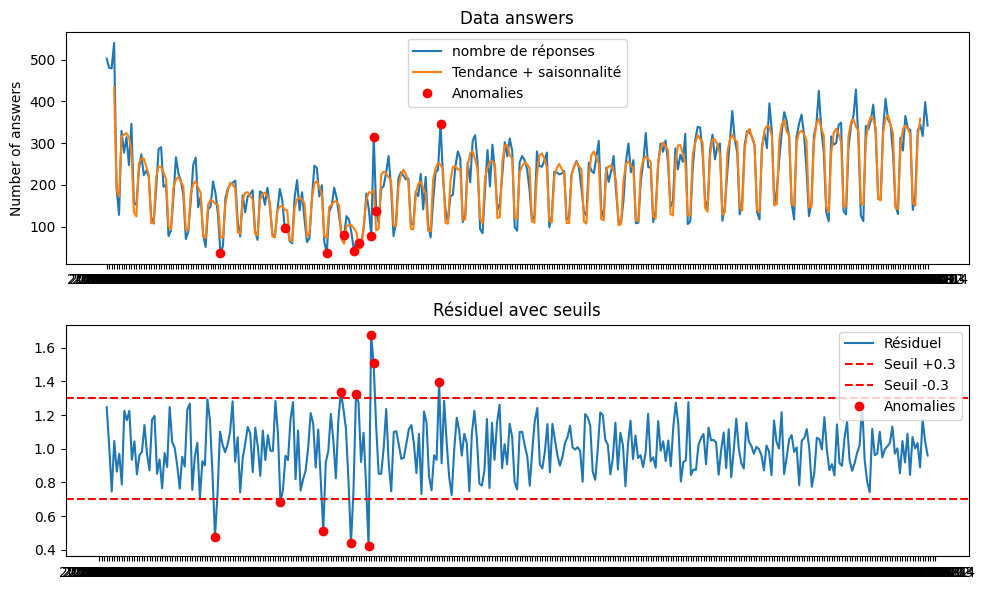

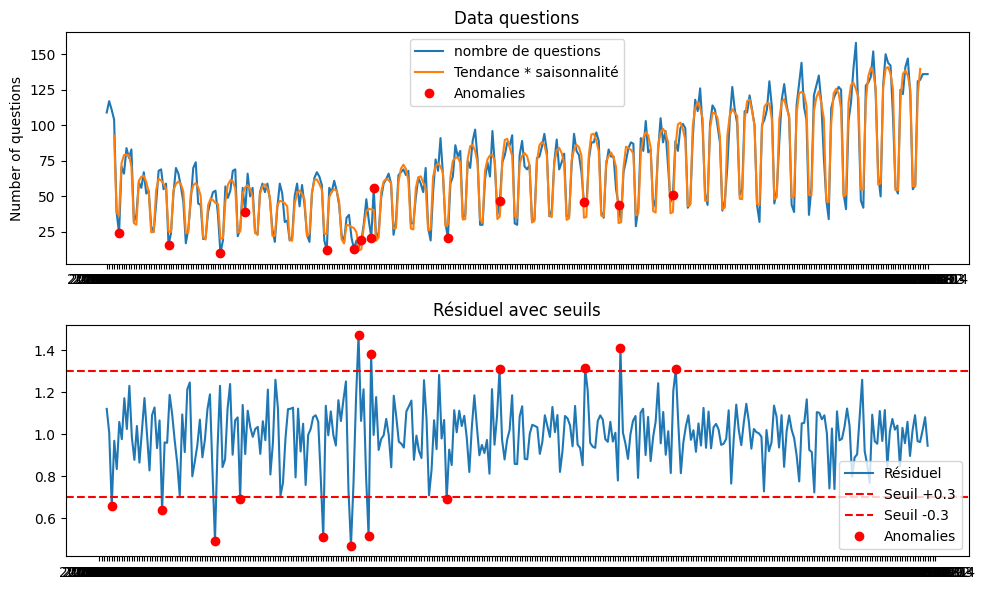

ANSWER : Anomalie détectée le 2008-12-21 avec une valeur de 79
ANSWER : Anomalie détectée le 2008-12-27 avec une valeur de 61
ANSWER : Anomalie détectée le 2009-01-02 avec une valeur de 314
ANSWER : Anomalie détectée le 2009-01-03 avec une valeur de 137
ANSWER : Anomalie détectée le 2009-01-29 avec une valeur de 346
ANSWER : Anomalie détectée le 2008-11-01 avec une valeur de 36
ANSWER : Anomalie détectée le 2008-11-27 avec une valeur de 96
ANSWER : Anomalie détectée le 2008-12-14 avec une valeur de 37
ANSWER : Anomalie détectée le 2008-12-25 avec une valeur de 42
ANSWER : Anomalie détectée le 2009-01-01 avec une valeur de 77
QUESTION : Anomalie détectée le 2008-12-28 avec une valeur de 19 
QUESTION : Anomalie détectée le 2009-01-02 avec une valeur de 56 
QUESTION : Anomalie détectée le 2009-02-22 avec une valeur de 47 
QUESTION : Anomalie détectée le 2009-03-28 avec une valeur de 46 
QUESTION : Anomalie détectée le 2009-04-11 avec une valeur de 44 
QUESTION : Anomalie détectée le 2009-

In [8]:
# Detection of anomalies

# Threshold for find anomalies
threshold = 0.30
threshold_question = 0.30
anomalies = np.where(answers_residual > 1 + threshold)[0]
anomalies = np.concatenate((anomalies, np.where(answers_residual < 1 - threshold)[0]))

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(answers_moy_by_day_for_plot, label='nombre de réponses')
ax[0].plot(answers_trend * answers_seasonal, label='Tendance + saisonnalité')

ax[0].plot(anomalies, answers_moy_by_day_for_plot[anomalies], 'ro', label='Anomalies')  # Points rouges aux indices des anomalies
ax[0].set_ylabel('Number of answers')
ax[0].set_title('Data answers')
ax[0].legend()

# Tracé du résiduel avec les lignes de seuil
ax[1].plot(answers_residual, label='Résiduel')
ax[1].axhline(1 + threshold, color='r', linestyle='--', label=f'Seuil +{threshold}')
ax[1].axhline(1 - threshold, color='r', linestyle='--', label=f'Seuil -{threshold}')
ax[1].plot(anomalies, answers_residual[anomalies], 'ro', label='Anomalies') 
ax[1].set_title('Résiduel avec seuils')
ax[1].legend()

plt.tight_layout()
plt.savefig('answers_anomalies.png')
plt.show()

question_anomalies = np.where(question_residual > 1 + threshold_question)[0]
question_anomalies = np.concatenate((question_anomalies, np.where(question_residual < 1 - threshold_question)[0]))

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Tracé des données originales avec les anomalies
ax[0].plot(question_moy_by_day_for_plot, label='nombre de questions')
# Tendance + saisonnalité
ax[0].plot(question_trend * question_seasonal, label='Tendance * saisonnalité')

ax[0].plot(question_anomalies, question_moy_by_day_for_plot[question_anomalies], 'ro', label='Anomalies')  # Points rouges aux indices des anomalies
ax[0].set_ylabel('Number of questions')
ax[0].set_title('Data questions')
ax[0].legend()

# Tracé du résiduel avec les lignes de seuil
ax[1].plot(question_residual, label='Résiduel')
ax[1].axhline(1 + threshold_question, color='r', linestyle='--', label=f'Seuil +{threshold_question}')
ax[1].axhline(1 - threshold_question, color='r', linestyle='--', label=f'Seuil -{threshold_question}')
ax[1].plot(question_anomalies, question_residual[question_anomalies], 'ro', label='Anomalies') 
ax[1].set_title('Résiduel avec seuils')
ax[1].legend()

plt.tight_layout()
plt.savefig('questions_anomalies.png')
plt.show()


# Print days answer anomalies
for i, index in enumerate(anomalies):
    print(f'ANSWER : Anomalie détectée le {answers_moy_by_day_for_plot.index[index]} avec une valeur de {answers_moy_by_day_for_plot[index]}')

# Print days question anomalies
for i, index in enumerate(question_anomalies):
    print(f'QUESTION : Anomalie détectée le {question_moy_by_day_for_plot.index[index]} avec une valeur de {question_moy_by_day_for_plot[index]} ')



/tmp/ipykernel_29813/3024224629.py:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  by_tag = by_tag[(by_tag['CreationDate'] <= pd.to_datetime(date_end)) & (by_tag['CreationDate'] >= pd.to_datetime(date_start))]
/tmp/ipykernel_29813/3024224629.py:14: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  total_date = total_date[(total_date['CreationDate'] <= pd.to_datetime(date_end)) & (total_date['CreationDate'] >= pd.to_datetime(date_start))]


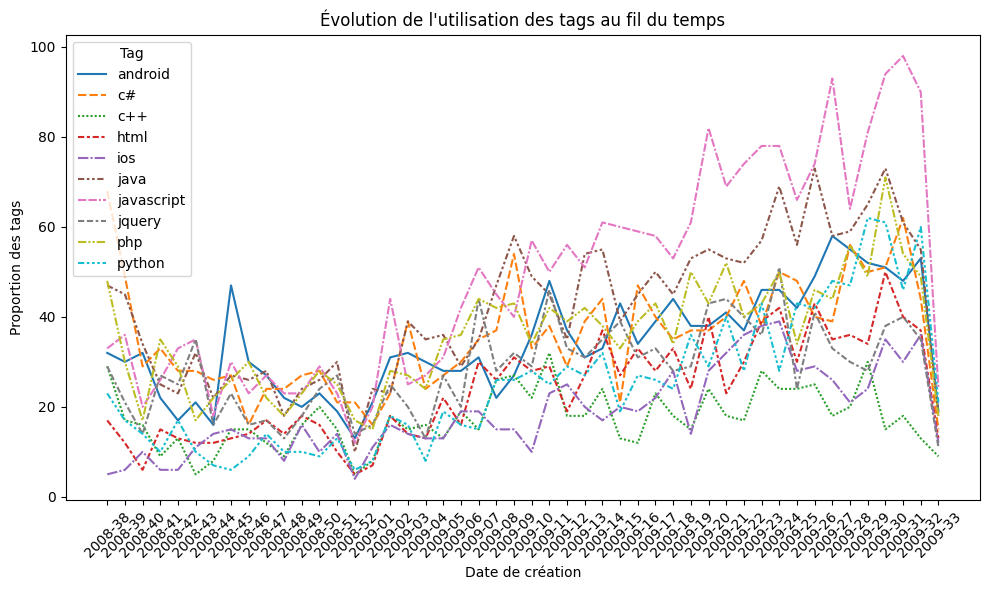

In [9]:

by_tag = questions_top[['CreationDate', 'Tag']].copy()
total_date = questions[['CreationDate', 'Tag']].copy()
by_tag['CreationDate'] = pd.to_datetime(by_tag['CreationDate'])
by_tag['CreationDate'] = by_tag['CreationDate'].dt.date
total_date['CreationDate'] = pd.to_datetime(total_date['CreationDate'])
total_date['CreationDate'] = total_date['CreationDate'].dt.date

# year and month and week
by_tag = by_tag[(by_tag['CreationDate'] <= pd.to_datetime(date_end)) & (by_tag['CreationDate'] >= pd.to_datetime(date_start))]
by_tag['CreationDate'] = by_tag['CreationDate'].apply(lambda x: f"{pd.Timestamp(x).year}-{pd.Timestamp(x).isocalendar().week:02d}")
by_tag['CreationDate'] = by_tag['CreationDate'].apply(lambda x: '2009-01' if x == '2008-01' else x)  # Change 2008-01 to 2009-01
# because the last part week of 2008 is not complete and it's the first week of 2009

total_date = total_date[(total_date['CreationDate'] <= pd.to_datetime(date_end)) & (total_date['CreationDate'] >= pd.to_datetime(date_start))]
total_date['CreationDate'] = total_date['CreationDate'].apply(lambda x: f"{pd.Timestamp(x).year}-{pd.Timestamp(x).isocalendar().week:02d}")
total_date['CreationDate'] = total_date['CreationDate'].apply(lambda x: '2009-01' if x == '2008-01' else x)



by_tag = by_tag.explode('Tag').reset_index()
# unique_years = by_tag['CreationDate'].unique()
by_tag = by_tag[by_tag['Tag'].isin(top_tags)]
# unique_years = by_tag['CreationDate'].unique()
by_tag = by_tag.groupby(['Tag', 'CreationDate']).size().reset_index(name='count')


# unique_years = by_tag['CreationDate'].unique()
# display courbe of activity by tag
by_tag_pivot = by_tag.pivot(index='CreationDate', columns='Tag', values='count').fillna(0)
by_tag_popular_beetwen = by_tag_pivot.div(by_tag_pivot.sum(axis=1), axis=0)

total_date = total_date.groupby('CreationDate').size().reset_index(name='count').fillna(0)
by_tag_popular_total = by_tag_pivot.div(total_date.set_index('CreationDate')['count'], axis=0).fillna(0)


plt.figure(figsize=(10, 6))
sns.lineplot(data=by_tag_pivot)
plt.title('Évolution de l\'utilisation des tags au fil du temps')
plt.xlabel('Date de création')
plt.ylabel('Proportion des tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plot_tag_evolution.png')

for tag in top_tags :
    # Get data for tag
    data = by_tag_pivot[tag]
    plot_acf(data)
    acf_values = acf(data)
    top_3_lags_questions = np.argsort(acf_values)[-4:-1]  # Exclude lag 0
    for lag in top_3_lags_questions:
        plt.axvline(x=lag, color='r', linestyle='--')
        plt.text(x=lag, y=-0.9, s=f'{lag}', rotation=0, color='red')
    plt.title(f'Autocorrelation for tag {tag}')
    plt.savefig(f'acf/acf_{tag}.png')
    plt.close()


Voir les acf dans le dossier acf. Nous remarquons que les acf ne montre pas de cycle. Les données ne sont plus par jour mais par semaine. Car il n'y a pas assez de données. Nous ne voyons pas de cycles, donc il n'est pas pertinant de faire de la décomposition de saisonalité.

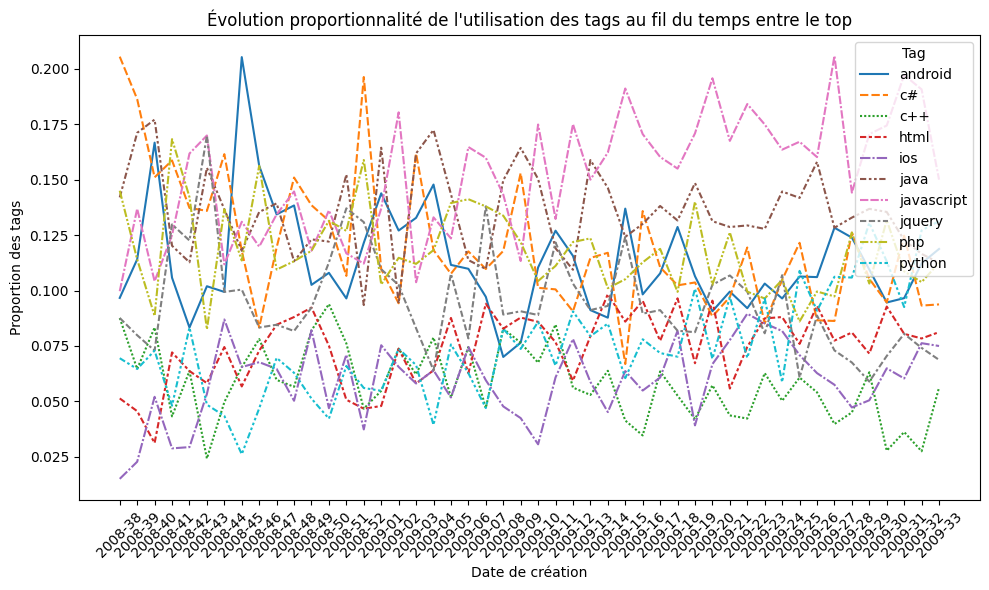

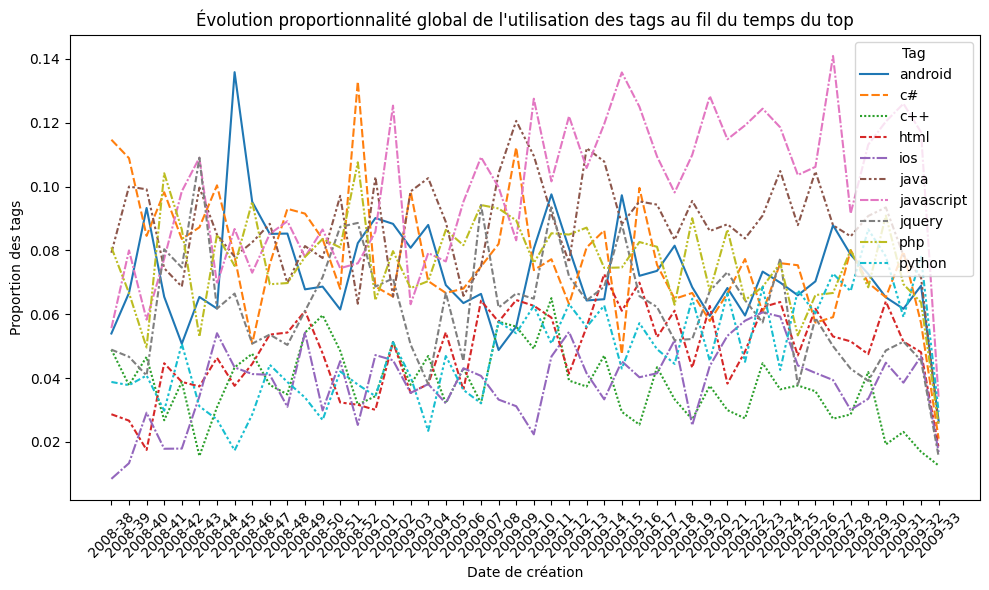

In [10]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=by_tag_popular_beetwen)
plt.title('Évolution proportionnalité de l\'utilisation des tags au fil du temps entre le top')
plt.xlabel('Date de création')
plt.ylabel('Proportion des tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=by_tag_popular_total)
plt.title('Évolution proportionnalité global de l\'utilisation des tags au fil du temps du top')
plt.xlabel('Date de création')
plt.ylabel('Proportion des tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for tag in top_tags :
    # Get data for tag
    data = by_tag_popular_total[tag]
    plot_acf(data)
    plt.title(f'Autocorrelation proportional for tag {tag}')
    plt.savefig(f'acf/acf_porcent_{tag}.png')
    plt.close()


Nous pouvons voir que nous pouvons prendre les questions de seulmenet les meilleurs top. Car les courbes sont similaire

In [11]:
# Convert the DataFrame to a NumPy array
timeseries = np.array(by_tag_pivot.values, dtype=np.double)

# Compute the distance matrix using dtw.distance_matrix_fast()
ds = dtw.distance_matrix_fast(timeseries)

for tag1 in top_tags:
    for tag2 in top_tags:
        if tag1 != tag2:
            s1 = by_tag_pivot[tag1]
            s2 = by_tag_pivot[tag2]
            # Centred and normalized
            s1 = (s1 - s1.mean()) / s1.std()
            s2 = (s2 - s2.mean()) / s2.std()
            d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
            best_path = dtw.best_path(paths)
            dtwvis.plot_warpingpaths(s1, s2, paths, best_path)
            plt.title(f'DTW distance between {tag1} and {tag2} : {d}')
            plt.savefig(f'timewarp/dtw_{tag1}_{tag2}.png')
            plt.close()

Ici sur les X top tags, nous pouvons voir que les time warp donne

In [12]:
timeseries = np.array(by_tag_popular_total.values, dtype=np.double)

# Compute the distance matrix using dtw.distance_matrix_fast()
ds = dtw.distance_matrix_fast(timeseries)

for tag1 in top_tags:
    for tag2 in top_tags:
        if tag1 != tag2:
            s1 = by_tag_popular_total[tag1]
            s2 = by_tag_popular_total[tag2]
            # Centred and normalized
            s1 = (s1 - s1.mean()) / s1.std()
            s2 = (s2 - s2.mean()) / s2.std()
            d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
            best_path = dtw.best_path(paths)
            dtwvis.plot_warpingpaths(s1, s2, paths, best_path)
            plt.title(f'DTW distance between {tag1} and {tag2} : {d}')
            plt.savefig(f'timewarp/dtw_porcent_{tag1}_{tag2}.png')
            plt.close()

            plt.figure(figsize=(20, 5))
            plt.plot(by_tag_popular_total[tag1], label='Series answers', color='blue', marker='o')
            plt.plot(by_tag_popular_total[tag2], label='Series questions', color='orange', marker='o')
            for a, b in best_path:
                plt.plot([a, b], [by_tag_popular_total[tag1][a], by_tag_popular_total[tag2][b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
            plt.title('Point-to-Point Comparison After DTW Alignment')
            plt.legend()
            plt.savefig(f'timewarp/plot_dtw_{tag1}_{tag2}.png')
            plt.close()


TODO


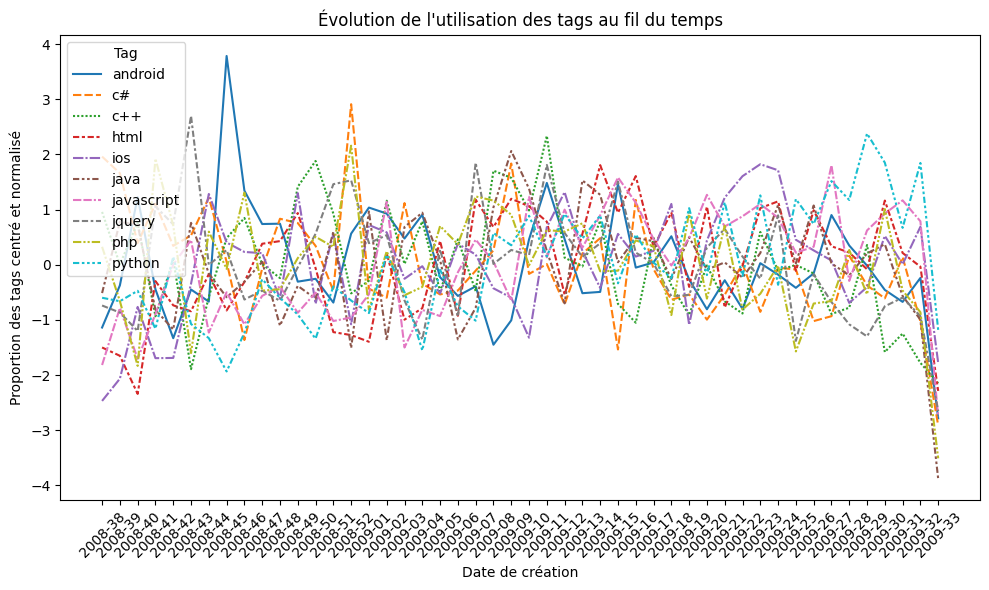

Cluster 1 : ['android']
Cluster 2 : ['javascript', 'java', 'c#', 'php', 'jquery', 'python', 'html', 'c++', 'ios']
Cluster 3 : []


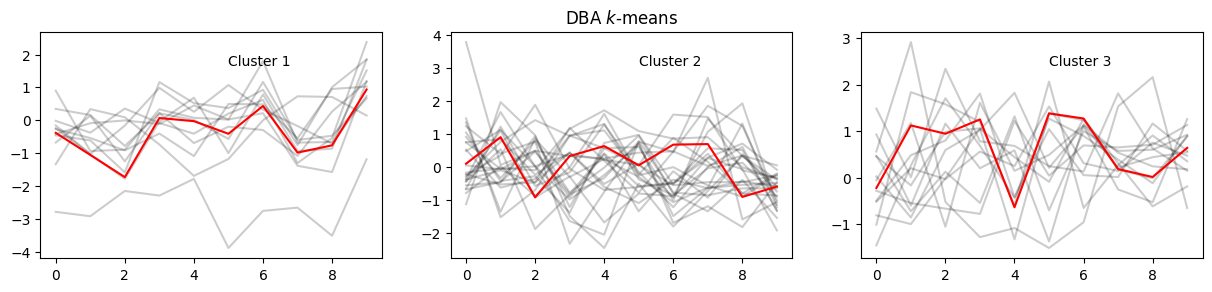

In [ ]:
# Centred and normalized
# https://tslearn.readthedocs.io/en/stable/user_guide/clustering.html

nb_clusters = 2
tag_cluster = by_tag_popular_total.copy()
tag_cluster = (tag_cluster - tag_cluster.mean()) / tag_cluster.std()

# plot tag cluster
plt.figure(figsize=(10, 6))
sns.lineplot(data=tag_cluster)
plt.title('Évolution de l\'utilisation des tags au fil du temps')
plt.xlabel('Date de création')
plt.ylabel('Proportion des tags centré et normalisé')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

model = TimeSeriesKMeans(n_clusters=nb_clusters, metric="dtw",
                         max_iter=10)

# model = KernelKMeans(n_clusters=5,
#                       kernel="gak",
#                       kernel_params={"sigma": "auto"},
#                       n_init=20)
y_pred = model.fit_predict(tag_cluster)

sz = by_tag_pivot.shape[1]

plt.figure(figsize=(15, 10))

for yi in range(nb_clusters):
    plt.subplot(3, 3, 4 + yi)
    for xx in tag_cluster.values[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
        
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

# For each cluster, print the tags
for i in range(nb_clusters):
    cluster_indices = np.where(y_pred == i)[0]
    cluster_tags = [top_tags[idx] for idx in cluster_indices if idx < len(top_tags)]
    print(f"Cluster {i+1} : {cluster_tags}")

plt.savefig(f'cluster_tag{nb_clusters}.png')



Les clusters trouver avec du time warping ne semble pas très pertinent.